In [1]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from fdsolver import FDTD1D
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device = {device}')

Device = cuda


Solving the wave equation with point source is common when simulating the wave phenomenon. The theoretical solution of it is complex. In this case, we use the solution computed by FD solver as exact solution and boundary data.
\begin{equation}
\begin{split}
&u_{tt} - c^2u_{xx} = \delta(x-x_0)w(t), -1 < x < 1, t > 0 \\
&u(x, 0) = u_t(x, 0) = 0
\end{split}
\end{equation}

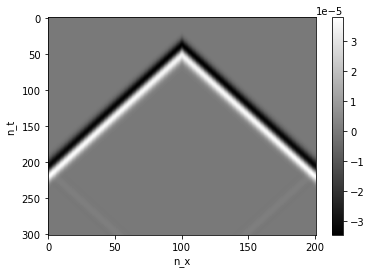

In [2]:
# Fd solver
c = np.ones(201) * 2
nx = 200
h = 0.01
dt = 0.003
nt = 300
x0 = 100
f0 = 10
solver = FDTD1D(h, dt, c, nt, x0, f0)
solver.steps()
solver.plot_wavefield()

In [3]:
# x = 0
u0 = solver.wavefield[:,0].reshape(-1, 1)
x0 = np.zeros(nt+1)
t0 = np.arange(nt+1) * dt
xt0 = np.c_[x0[:, np.newaxis], t0[:, np.newaxis]]
# x = L
ul = solver.wavefield[:, -1].reshape(-1, 1)
xl = np.ones(nt+1) * (nx * h)
tl = t0 = np.arange(nt+1) * dt
xtl = np.c_[xl[:, np.newaxis], tl[:, np.newaxis]]

XTb = np.r_[xt0, xtl]
Ub = np.r_[u0, ul]

In [4]:
class DNN(nn.Module):
    """Fully connected neural network
    """
    def __init__(self, layer_sizes):
        super(DNN, self).__init__()
        self.layer_sizes = layer_sizes
        self.linears = nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))

    def forward(self, x):
        for linear in self.linears[:-1]:
            # x = torch.nn.functional.softplus(linear(x))
            # x = torch.sigmoid(linear(x))
            # x = torch.nn.functional.relu(linear(x))
            x = torch.tanh(linear(x))
            # x = torch.sin(linear(x))
        x = self.linears[-1](x)
        return x 


class PINN(nn.Module):
    """Physic informed neural network
    """
    def __init__(self, c, layer_sizes, XTb, Ub, Ni, Nc):
        super(PINN, self).__init__()
        self.c = c

        # Initial condition
        xi = np.random.uniform(0, 2, (Ni, 1))
        self.xi = torch.tensor(xi, dtype=torch.float32, requires_grad=True, device=device)
        self.ti = torch.zeros(Ni, 1, dtype=torch.float32, requires_grad=True, device=device)
        
        # Boundary condition
        self.xb = torch.tensor(XTb[:, 0:1], dtype=torch.float32, requires_grad=True, device=device)
        self.tb = torch.tensor(XTb[:, 1:2], dtype=torch.float32, requires_grad=True, device=device)
        self.ub = torch.tensor(Ub, dtype=torch.float32, device=device)
        self.ub_max = self.ub.max()
        self.ub_min = self.ub.min()
        
        # Collocation points
        xf = np.random.uniform(0, 2, (Nc, 1))
        tf = np.random.uniform(0, 1, (Nc, 1))
        self.xf = torch.tensor(xf, dtype=torch.float32, requires_grad=True, device=device)
        self.tf = torch.tensor(tf, dtype=torch.float32, requires_grad=True, device=device)
        
        # Deal with l2 error
        # Exact data
        x = np.arange(nx + 1) * h 
        t = np.arange(nt + 1) * dt 
        X, T = np.meshgrid(x, t)
        self.x_star = X.flatten()[:, np.newaxis]
        self.t_star = T.flatten()[:, np.newaxis]
        self.u_star = solver.wavefield.flatten()[:, np.newaxis]
        self.error = []
            
        self.loss = []
        self.dnn = DNN(layer_sizes).to(device)
        self.iter = 0
        self.max_num_iter = 5000
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        # self.optimizer = torch.optim.Adam(
        #     self.dnn.parameters(), 
        #     lr=0.01, 
        # )
        
    def net_u(self, x, t):
        # u = self.dnn(torch.cat((x, t), dim=1)) * (self.ub_max - self.ub_min) + self.ub_min
        u = self.dnn(torch.cat((x, t), dim=1)) * (8e-6)
        return u 

    def net_f(self, x, t):
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        Lu = u_tt  - self.c ** 2 * u_xx
        return Lu 
    
    def compute_error(self):
        u_pred, _ = self.predict(self.x_star, self.t_star)
        error = np.linalg.norm(self.u_star-u_pred,2)/np.linalg.norm(self.u_star,2)
        error = error ** 2
        self.error.append(error)
        self.dnn.train()

    def loss_func(self):
        self.compute_error()
        self.optimizer.zero_grad()
        
        ui = self.net_u(self.xi, self.ti)
        ui_t = torch.autograd.grad(
            ui, self.ti,
            grad_outputs=torch.ones_like(ui),
            retain_graph=True,
            create_graph=True
        )[0]
        loss_i = torch.mean(ui ** 2) + torch.mean(ui_t ** 2)
        
        f_pred = self.net_f(self.xf, self.tf)
        loss_f = torch.mean(f_pred ** 2)
        
        ub = self.net_u(self.xb, self.tb)
        loss_b = torch.mean((ub - self.ub) ** 2)

        loss = loss_i + loss_b +  loss_f
        loss = loss * 1e10
        self.loss.append(loss.item())
        
        loss.backward()
        
        if self.iter % 100 == 0:
            print("Iter %d, Loss: %.4e, Initial loss: %.4e, Boundary loss: %.4e, Collocation loss : %.4e" 
                  % (self.iter, loss.item(), loss_i.item(), loss_b.item(), loss_f.item()))
        self.iter += 1
        return loss

    def train(self):
        self.dnn.train()
        while self.iter < self.max_num_iter:
            self.optimizer.step(self.loss_func)

            
    def predict(self, x, t):
        self.dnn.eval() 
        x = torch.tensor(x, requires_grad=True, dtype=torch.float32, device=device)
        t = torch.tensor(t, requires_grad=True, dtype=torch.float32, device=device)
        u = self.net_u(x, t)
        Lu = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        Lu = Lu.detach().cpu().numpy()
        return u, Lu

In [5]:
c = 2
layer_sizes = [2] + [20] * 10 + [1]
Ni = 500
Nc = 10000
model = PINN(c, layer_sizes, XTb, Ub, Ni, Nc)

In [6]:
model.train()

Iter 0, Loss: 8.1848e-01, Initial loss: 5.4561e-12, Boundary loss: 7.6392e-11, Collocation loss : 1.5511e-17
Iter 100, Loss: 7.0944e-01, Initial loss: 3.1705e-17, Boundary loss: 7.0944e-11, Collocation loss : 2.3930e-17
Iter 200, Loss: 7.0944e-01, Initial loss: 3.1705e-17, Boundary loss: 7.0944e-11, Collocation loss : 2.3930e-17


KeyboardInterrupt: 

The lowest error is 0.99998961


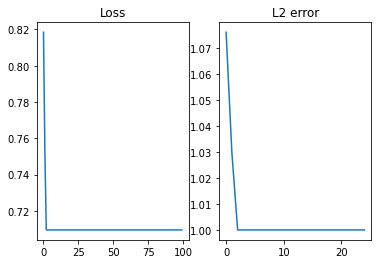

In [7]:
loss, error = model.loss, model.error
fig, ax = plt.subplots(1, 2)
ax[0].plot(loss[:100])

ax[0].set_title('Loss')
ax[1].plot(error[:25])
ax[1].set_title('L2 error')
loss = np.array(loss)
error = np.array(error)
print(f'The lowest error is {error.min():.8f}')

In [8]:
u_pred, _ = model.predict(model.x_star, model.t_star)

In [9]:
u_pred = u_pred.reshape(301, 201)

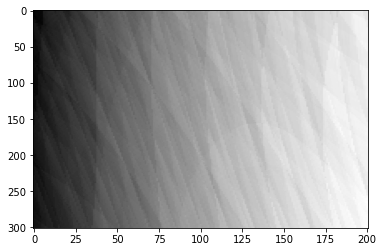

In [10]:
plt.imshow(u_pred, cmap="gray", aspect="auto")

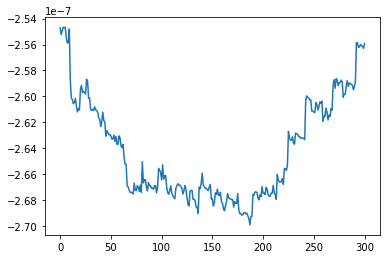

In [60]:
plt.plot(u_pred[:, -1])

In [62]:
u_pred.min()

-2.6990529e-07

In [64]:
u_pred0 = u_pred[:, 0].reshape(-1, 1)
np.mean(np.square(u0-u_pred0))

7.09687499829617e-11

In [9]:
Ub.std()

8.422861979767505e-06